In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from transformers import AutoTokenizer, TFBartForConditionalGeneration
from rouge import Rouge

In [ ]:
model = TFBartForConditionalGeneration.from_pretrained("sshleifer/distilbart-cnn-12-6", from_pt=True)
tokenizer = AutoTokenizer.from_pretrained("sshleifer/distilbart-cnn-12-6")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBartForConditionalGeneration: ['model.decoder.embed_tokens.weight', 'model.encoder.embed_tokens.weight']
- This IS expected if you are initializing TFBartForConditionalGeneration from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBartForConditionalGeneration from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBartForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


## Testing
First off, we run some tests to check everything works properly. In particular, we will concentrate on the extractive summarization distilbart model to check how to tune the hyperparameters.

In [ ]:
ROUGE = Rouge()

# test for functioning
reference = 'We really want to get a high grade for this group work.'
candidate = 'We are convinced we deserve a high grade for the group work we have produced.'

ROUGE.get_scores(candidate, reference)

[{'rouge-1': {'r': 0.5833333333333334, 'p': 0.5, 'f': 0.5384615334911242},
  'rouge-2': {'r': 0.36363636363636365,
   'p': 0.2857142857142857,
   'f': 0.31999999507200005},
  'rouge-l': {'r': 0.5833333333333334, 'p': 0.5, 'f': 0.5384615334911242}}]

In [ ]:
# running example to test time and length performance of the summarization model
example_paragraph = """National Alliance was a conservative political party in Italy. It was the successor of the Italian Social Movement , a neo-fascist party founded in 1946 by former followers of Benito Mussolini that had moderated its policies over its last decades and finally distanced itself from its former ideology, a move known as post-fascismo , during a convention in Fiuggi by dissolving into the new party in 1995. Gianfranco Fini was the leader of AN from its foundation through 2008, after being elected President of the Chamber of Deputies. Fini was succeeded by Ignazio La Russa, who managed the merger of the party with Forza Italia into The People of Freedom in 2009. A group of former AN members, led by La Russa, left PdL in 2012 to launch the Brothers of Italy , while others remained in the PdL and were among the founding members of the relaunched Forza Italia in 2013. National Alliance was launched in 1994 when the Italian Social Movement , the former neo-fascist party, merged with conservative elements of the former Christian Democracy, which had disbanded in 1994 after two years of scandals and various splits due to political corruption at its highest levels, exposed by the Mani pulite investigation, and the Italian Liberal Party, disbanded in the same year. It was officially launched in January 1995. Former MSI members dominated the new party, and the MSI's last leader, Gianfranco Fini, was elected the new party's first leader. The AN logo followed a template very similar to that of the Democratic Party of the Left, incorporating the MSI logo in a small roundel of the AN logo as a means of legally preventing others from using it. The name was suggested by an article on the Italian newspaper Il Tempo written in 1992 by Domenico Fisichella, a prominent conservative academic. Starting in the 1990s, the MSI gradually transformed into a mainstream right-wing party, culminating in its 1995 dissolution into AN. The party was part of all three House of Freedoms coalition governments led by Silvio Berlusconi. Fini was nominated Deputy Prime Minister after the 2001 Italian general election and was Foreign Minister from November 2004 to May 2006. When Fini visited Israel in late November 2003 in the function of Italian Deputy Prime Minister, he labelled the racial laws issued by the Italian fascism regime in 1938 as "infamous", as also Giorgio Almirante, historic leader of MSI, had done before. He also referred to the Italian Social Republic as belonging to the most shameful pages of the past, and considered fascism part of an era of "absolute evil", something which was hardly acceptable to the few remaining hardliners of the party. As a result, Alessandra Mussolini, the granddaughter of the former fascist dictator Benito Mussolini, who had been at odds with the party on a number of issues for a long time, and some hardliners left the party and formed Social Action. In occasion of the 2006 Italian general election, AN ran within the House of Freedoms, with new allies. The centre-right lost by 24,000 votes in favour of the centre-left coalition The Union. Individually, AN received nearly 5 million votes, amounting to 12. 3%. In July 2007, a group of splinters led by Francesco Storace formed The Right, which was officially founded on 10 November. Seven MPs of AN, including Teodoro Buontempo and Daniela Santanchè, joined the new party. In November 2007, Silvio Berlusconi announced that Forza Italia would have soon merged or transformed into The People of Freedom party."""
summaries = []

In [ ]:
# basic statistics on the paragraph
print(f"Number of characters:   {len(example_paragraph)}")
print(f"Number of words:        {len(example_paragraph.split(' '))}")
print(f"Number of sentences:    {len(example_paragraph.split('.'))}")

Number of characters:   3513
Number of words:        585
Number of sentences:    24


To control the length of our summaries and check how it affects time performance, we will test various values for the `min_length` and `max_length` parameters, which bound the number of generated tokens in the output. We only test on one paragraph as we can effectively choose the length of the output, and so we are just interested in finding the most similar length output to the concept map model (to make the two comparable) considering the tradeoff with computational time required to compute longer summaries.

In [ ]:
%%time
inputs = tokenizer([example_paragraph], return_tensors="pt")

# model with default settings
summary_ids = model.generate(inputs["input_ids"])
summaries.append(tokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)[0])

# basic statistics on the summary
print(f"Number of characters:   {len(summaries[-1])}")
print(f"Number of words:        {len(summaries[-1].split(' '))}")
print(f"Number of sentences:    {len(summaries[-1].split('.'))}")

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:854: UserWarning: Using `max_length`'s default (142) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Number of characters:   372
Number of words:        60
Number of sentences:    4
CPU times: user 1min 9s, sys: 11.4 s, total: 1min 20s
Wall time: 1min 39s


In [ ]:
%%time
inputs = tokenizer([example_paragraph], return_tensors="pt")

summary_ids = model.generate(inputs["input_ids"], min_length=100, max_length = 200)
summaries.append(tokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)[0])

# basic statistics on the summary
print(f"Number of characters:   {len(summaries[-1])}")
print(f"Number of words:        {len(summaries[-1].split(' '))}")
print(f"Number of sentences:    {len(summaries[-1].split('.'))}")

Number of characters:   475
Number of words:        79
Number of sentences:    5
CPU times: user 1min 24s, sys: 14.5 s, total: 1min 38s
Wall time: 1min 46s


In [ ]:
%%time
inputs = tokenizer([example_paragraph], return_tensors="pt")

summary_ids = model.generate(inputs["input_ids"], min_length=150, max_length = 300)
summaries.append(tokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)[0])

# basic statistics on the summary
print(f"Number of characters:   {len(summaries[-1])}")
print(f"Number of words:        {len(summaries[-1].split(' '))}")
print(f"Number of sentences:    {len(summaries[-1].split('.'))}")

Number of characters:   677
Number of words:        116
Number of sentences:    7
CPU times: user 1min 53s, sys: 20.4 s, total: 2min 13s
Wall time: 2min 12s


In [ ]:
%%time
inputs = tokenizer([example_paragraph], return_tensors="pt")

summary_ids = model.generate(inputs["input_ids"], min_length=200, max_length = 400)
summaries.append(tokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)[0])

# basic statistics on the summary
print(f"Number of characters:   {len(summaries[-1])}")
print(f"Number of words:        {len(summaries[-1].split(' '))}")
print(f"Number of sentences:    {len(summaries[-1].split('.'))}")

Number of characters:   878
Number of words:        148
Number of sentences:    9
CPU times: user 2min 25s, sys: 26.3 s, total: 2min 51s
Wall time: 2min 34s


In [ ]:
%%time
inputs = tokenizer([example_paragraph], return_tensors="pt")

summary_ids = model.generate(inputs["input_ids"], min_length=400, max_length = 800)
summaries.append(tokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)[0])

# basic statistics on the summary
print(f"Number of characters:   {len(summaries[-1])}")
print(f"Number of words:        {len(summaries[-1].split(' '))}")
print(f"Number of sentences:    {len(summaries[-1].split('.'))}")

Number of characters:   1616
Number of words:        270
Number of sentences:    19
CPU times: user 4min 45s, sys: 53.3 s, total: 5min 38s
Wall time: 5min 15s


In [ ]:
%%time
inputs = tokenizer([example_paragraph], return_tensors="pt")

summary_ids = model.generate(inputs["input_ids"], min_length=600, max_length = 1200)
summaries.append(tokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)[0])

# basic statistics on the summary
print(f"Number of characters:   {len(summaries[-1])}")
print(f"Number of words:        {len(summaries[-1].split(' '))}")
print(f"Number of sentences:    {len(summaries[-1].split('.'))}")

Number of characters:   2620
Number of words:        434
Number of sentences:    25
CPU times: user 7min 7s, sys: 1min 18s, total: 8min 26s
Wall time: 7min 17s


Let's collect the results obtained thus far.

In [ ]:
summaries_stats = pd.DataFrame({"summary":summaries})
summaries_stats["nchar"]   = summaries_stats["summary"].str.len()
summaries_stats["nwords"]  = summaries_stats["summary"].str.split(' ').apply(len)
summaries_stats["nsents"]  = summaries_stats["summary"].str.split('.').apply(len)

Now, we check how the summaries by distilbart compare to the ones which can be obtained from our concept maps. First, we look at a small dataset of 25 paragraphs in which the concept map produced by our model has been stored as a text and that we have manully annotated. Then, we will base our evaluation on a larger dataset of randomly selected Wikipedia paragraphs of which we produced concept maps.

In [ ]:
# sample of 25 paragraphs and the corresponding concept maps
sample = pd.read_csv("df_rouge_24.csv")

# dataset of 253 paragraphs and the corresponding concept maps
data   = pd.read_csv("rouge_data_250.csv")

In [ ]:
sample["nchar"]   = sample["Model_summary"].str.len()
sample["nwords"]  = sample["Model_summary"].str.split(' ').apply(len)
sample["nsents"]  = sample["Model_summary"].str.split('.').apply(len)

In [ ]:
sample.head()

,title,Model_summary,Original_text,nchar,nwords,nsents
0,Brenton Tarrant,New Zealand was named the second-most peaceful...,"On 15 March 2019, two consecutive mass shootin...",475,76,8
1,Pugachev'S Rebellion,The Great ceded entire villages. Pugachev 's i...,The rebellion managed to consolidate support f...,881,136,14
2,Kingdom Of Naples,The territory corresponded to the current Ital...,"As part of the Italian Wars, France went to wa...",801,135,11
3,Battle Of Actium,Mark were stationed in 31 bc. Mark sailed thro...,"In early 31 BC, the year of the battle, Antony...",704,117,12
4,William Mckinley,Thousands of men in Ohio volunteered for servi...,The family moved to Ohio when the senior McKin...,653,99,14


Let's see how the model statistics compare to the concept maps ones.

In [ ]:
summaries_stats.iloc[:,1:]

,nchar,nwords,nsents
0,372,60,4
1,475,79,5
2,677,116,7
3,878,148,9
4,1616,270,19
5,2620,434,25


In [ ]:
sample.describe()

,nchar,nwords,nsents
count,25.000000,25.000000,25.000000
mean,800.160000,127.680000,12.440000
std,184.899901,31.873082,2.709243
min,425.000000,64.000000,8.000000
25%,700.000000,114.000000,10.000000
50%,801.000000,127.000000,13.000000
75%,908.000000,145.000000,14.000000
max,1205.000000,202.000000,18.000000


It seems like configuration 3 (index 2 in the df) is the more suited as, together with configuration 4, it results in an output of most similar length (in terms of characters, words and phrases) to the one provided by the concept map model. However it obviously has a lower computational cost. Moreover, note that the lower number of sentences in the Bart summaries is most probably due to the fact that the concept map model prediliges shorter sentences, as they are used to represent different singular relations. Thus, we will stick with it; this means we will choose `min_length = 150` and `max_length = 300`.

## Summaries production
We will now construct the Bart summaries to evaluate the concept maps summarization power. First we apply it to the small dataset of manually annotated concept maps, and then to the full dataset of 250 concept maps which we produced from randomly selected wikipedia paragraphs.

In [ ]:
def get_summary(p):
  """
    Obtain summary of a paragraph p or return missing value
  """
  try:
    inputs = tokenizer([p], return_tensors="pt")
    summary_ids = model.generate(inputs["input_ids"], min_length=150, max_length = 300)
    return tokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)[0]
  
  except:
    return pd.NA

In [ ]:
sample["Bart_summary"] = sample["Original_text"].apply(get_summary)
sample.to_csv("../data/sample25.csv")

In [ ]:
# This cell produces the complete dataset with Bart summaries

%%time

data["Bart_summary"] = pd.NA

for i, row in data.iterrows():

  summary = get_summary(row["Original_text"])
  data.loc[i, "Bart_summary"] = summary
  
  # store data up to row i
  data.to_csv("../data/sample250.csv")

  print(f"row {i}")

## Model evaluation
After the creation of the Bart summaries, we move to the analysis of our model in terms of summarization ability. We will use the rouge-2 metric, as suggested by Nugumanova and Baiburin 2021.

### Sample 250
First we concentrate on the random sample of wiki pages, on which automatic maps were generated.

In [ ]:
data_annotated = pd.read_csv("../data/sample250.csv")
data_annotated.drop(["Unnamed: 0.1", "Unnamed: 0"], axis=1, inplace=True)
data_annotated.head()

,title,Model_summary,Original_text,Bart_summary
0,Battle Of Verdun,"An assault on Morchee Trench , Bonnet - d'Eveq...",9 mi front but several minor German attacks ca...,Mangin proposed a preliminary attack to retak...
1,Participatory Democracy,Thirty fourth Amendment of the Constitution of...,"Following a weekend of deliberation, the parti...","In the early 21st century, experiments in par..."
2,The Second Industrial Revolution: Industrial F...,Japan was eager to do so. Japan had become cap...,"Construction began in 1870; by 1872, a rail li...","By the end of the nineteenth century, Japan h..."
3,Qatar Corruption Scandal At The European Parli...,The Central Office for the Repression of Corru...,"Qatargate is an ongoing political scandal, inv...",Qatargate is an ongoing political scandal inv...
4,Ukraine Crisis,A representative of Mariupol supporters of the...,"On the same day, protesters in the city of Don...",Russian president Vladimir Putin asked the se...


In [ ]:
def compute_rouge(model_summary, bart_summary, stat):
  try:
    return ROUGE.get_scores(model_summary, bart_summary)[0]['rouge-2'][stat]
  except:
    return pd.NA

In [ ]:
data_annotated["rouge2_r"] = np.nan

for i, row in data_annotated.iterrows():
  rouge2_r = compute_rouge(row["Model_summary"], row["Bart_summary"], 'r')
  data_annotated.loc[i, "rouge2_r"] = rouge2_r

data_annotated["rouge2_r"] = data_annotated["rouge2_r"].astype(float)

In [ ]:
data_annotated["rouge2_p"] = np.nan

for i, row in data_annotated.iterrows():
  rouge2_p = compute_rouge(row["Model_summary"], row["Bart_summary"], 'p')
  data_annotated.loc[i, "rouge2_p"] = rouge2_p

data_annotated["rouge2_p"] = data_annotated["rouge2_p"].astype(float)

In [ ]:
data_annotated["rouge2_f"] = np.nan

for i, row in data_annotated.iterrows():
  rouge2_f = compute_rouge(row["Model_summary"], row["Bart_summary"], 'f')
  data_annotated.loc[i, "rouge2_f"] = rouge2_f

data_annotated["rouge2_f"] = data_annotated["rouge2_f"].astype(float)

We have computed precision, recall and the f1 score of the rouge-2 metric. Let's see some statistics.

In [ ]:
data_annotated.iloc[:,-3:].describe()

,rouge2_r,rouge2_p,rouge2_f
count,252.000000,252.000000,252.000000
mean,0.197506,0.179135,0.183759
std,0.123498,0.103134,0.107118
min,0.000000,0.000000,0.000000
25%,0.109342,0.114827,0.114405
50%,0.193130,0.175219,0.184220
75%,0.272922,0.245797,0.249195
max,0.565574,0.500000,0.487395


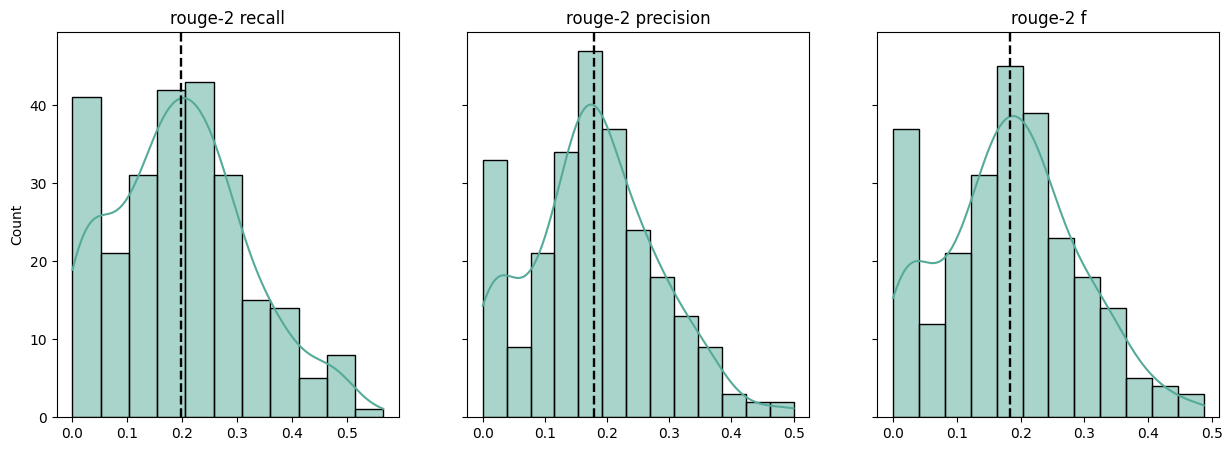

In [ ]:
figure, axes = plt.subplots(1, 3, sharey=True, figsize=(15,5))

COLOR = "#5A9"
sns.histplot(ax=axes[0], data=data_annotated["rouge2_r"], kde=True, color=COLOR).set(title="rouge-2 recall", xlabel=None)
axes[0].axvline(x = data_annotated["rouge2_r"].mean(), color="black", linestyle="dashed", linewidth=1.7)
sns.histplot(ax=axes[1], data=data_annotated["rouge2_p"], kde=True, color=COLOR).set(title="rouge-2 precision", xlabel=None)
axes[1].axvline(x = data_annotated["rouge2_p"].mean(), color="black", linestyle="dashed", linewidth=1.7)
sns.histplot(ax=axes[2], data=data_annotated["rouge2_f"], kde=True, color=COLOR).set(title="rouge-2 f", xlabel=None)
axes[2].axvline(x = data_annotated["rouge2_f"].mean(), color="black", linestyle="dashed", linewidth=1.7)

Note there is a spike at 0. Since the length of the concept map summaries was more variable than the one of the Bart summaries, let's see how this is associated with the f score of rouge-2. 

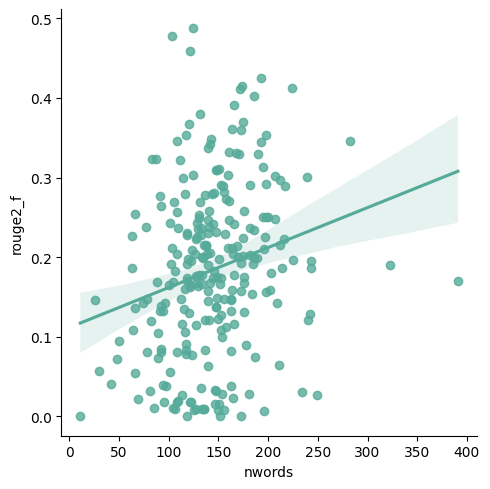

In [ ]:
data_annotated["nwords"]  = data_annotated["Model_summary"].str.split(' ').apply(len)
sns.lmplot(x="nwords", y="rouge2_f", data=data_annotated, scatter_kws={"color":COLOR}, line_kws={"color":COLOR})

No clear relationship emerges. The performance does not seem to be affected by how long the concept map is.

### Sample 25
Now we concentrate on the sample of 18 paragraphs which was manually annotated to run the user study, and for which also baseline maps were created. The different concept maps will be compared to Bart in terms of precision rouge, can be thought as the purity of the summary wrt to the reference considered.

In [ ]:
sample_annotated = pd.read_csv("../data/sample25_with_summaries.csv")
sample_annotated.drop("Unnamed: 0", axis=1, inplace=True)
sample_annotated.head()

,title,Original_text,Model_summary,Baseline,Handmade_Map,Bart_summary
0,Brenton Tarrant,"On 15 March 2019, two consecutive mass shootin...",New Zealand was named the second-most peaceful...,Two consecutive mass shootings occurred in a t...,Two consecutive mass shootings occurred in a t...,51 people were killed and 40 were injured in ...
1,Pugachev'S Rebellion,The rebellion managed to consolidate support f...,The Great ceded entire villages. Pugachev 's i...,The rebellion managed to consolidate support f...,Pugachev's Rebellion managed to consolidate su...,Yemelyan Pugachev's Rebellion was the largest...
2,Kingdom Of Naples,"As part of the Italian Wars, France went to wa...",The territory corresponded to the current Ital...,France went to war with Aragon. An Aragonese v...,France went to war with Aragon over the kingdo...,The territory of the Kingdom of Naples corres...
3,Battle Of Actium,"In early 31 BC, the year of the battle, Antony...",Mark were stationed in 31 bc. Mark sailed thro...,Cleopatra were stationed In 31 bc. Cleopatra w...,Antony and Cleopatra were temporary stationed ...,Mark Antony and Cleopatra were temporarily st...
4,William Mckinley,The family moved to Ohio when the senior McKin...,Thousands of men in Ohio volunteered for servi...,The senior McKinley settling in New Lisbon. Th...,"The family moved to Ohio, setting in New Lisbo...","McKinley moved to Ohio when he was a boy, set..."


In [ ]:
sample_annotated["rouge2_p_baseline"] = np.nan
sample_annotated["rouge2_p_model"] = np.nan
sample_annotated["rouge2_p_handmade"] = np.nan

for i, row in sample_annotated.iterrows():

  rouge2_p = compute_rouge(row["Baseline"], row["Bart_summary"], 'p')
  sample_annotated.loc[i, "rouge2_p_baseline"] = rouge2_p

  rouge2_p = compute_rouge(row["Model_summary"], row["Bart_summary"], 'p')
  sample_annotated.loc[i, "rouge2_p_model"] = rouge2_p

  rouge2_p = compute_rouge(row["Handmade_Map"], row["Bart_summary"], 'p')
  sample_annotated.loc[i, "rouge2_p_handmade"] = rouge2_p

sample_annotated["rouge2_p_baseline"] = sample_annotated["rouge2_p_baseline"].astype(float)
sample_annotated["rouge2_p_model"]    = sample_annotated["rouge2_p_model"].astype(float)
sample_annotated["rouge2_p_handmade"] = sample_annotated["rouge2_p_handmade"].astype(float)

In [ ]:
sample_annotated.iloc[:,-3:].describe()

,rouge2_p_baseline,rouge2_p_model,rouge2_p_handmade
count,18.000000,18.000000,18.000000
mean,0.154710,0.197934,0.223689
std,0.049607,0.086027,0.101921
min,0.079439,0.080357,0.087248
25%,0.126214,0.136235,0.142549
50%,0.148171,0.185134,0.231204
75%,0.182379,0.251241,0.277724
max,0.283333,0.402985,0.430303


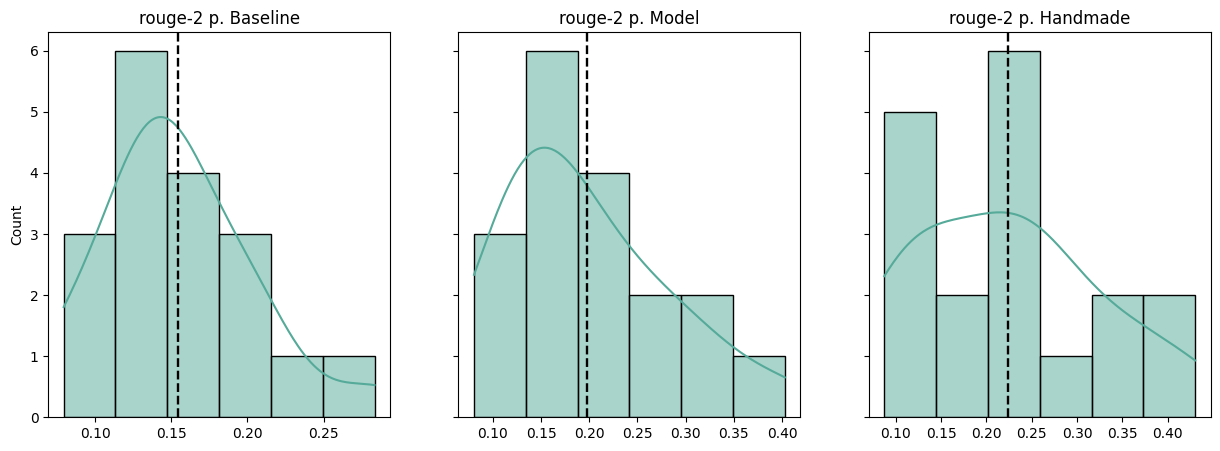

In [ ]:
figure, axes = plt.subplots(1, 3, sharey=True, figsize=(15,5))

sns.histplot(ax=axes[0], data=sample_annotated["rouge2_p_baseline"], kde=True, color=COLOR).set(title="rouge-2 p. Baseline", xlabel=None)
axes[0].axvline(x = sample_annotated["rouge2_p_baseline"].mean(), color="black", linestyle="dashed", linewidth=1.7)
sns.histplot(ax=axes[1], data=sample_annotated["rouge2_p_model"], kde=True, color=COLOR).set(title="rouge-2 p. Model", xlabel=None)
axes[1].axvline(x = sample_annotated["rouge2_p_model"].mean(), color="black", linestyle="dashed", linewidth=1.7)
sns.histplot(ax=axes[2], data=sample_annotated["rouge2_p_handmade"], kde=True, color=COLOR).set(title="rouge-2 p. Handmade", xlabel=None)
axes[2].axvline(x = sample_annotated["rouge2_p_handmade"].mean(), color="black", linestyle="dashed", linewidth=1.7)